In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define function to convert numerical ranks to ordinal format (e.g., 1st, 2nd)
def excel_rank_suffix(rank):
    try:
        rank = int(rank)
        if 11 <= rank % 100 <= 13:
            suffix = 'th'
        else:
            suffix = {1: 'st', 2: 'nd', 3: 'rd'}.get(rank % 10, 'th')
        return f"{rank}{suffix}"
    except:
        return ""

# Load all datasets
# Please change the path according to your directory
keys = pd.read_csv("C:/Users/adity/Downloads/KEYS.csv")
population = pd.read_csv("C:/Users/adity/Downloads/CENSUS_POPULATION_STATE.tsv", sep='\t')
mhi = pd.read_csv("C:/Users/adity/Downloads/CENSUS_MHI_STATE.csv")
sale_price = pd.read_csv("C:/Users/adity/Downloads/REDFIN_MEDIAN_SALE_PRICE.csv")

# Filter KEYS to only include states
keys = keys[(keys['region_type'].str.lower() == 'state')]

# Initialize output DataFrame and prepare key fields
output = pd.DataFrame()
output['key_row'] = keys['zillow_region_name'].astype(str).str.strip()
output['state_key'] = keys['census_msa'].astype(str).str.strip().str.lower()
output['display_name'] = keys['alternative_name'].fillna(keys['zillow_region_name']).str.title()

# Determine the latest month from Redfin data
latest_month = sale_price.columns[-1]
latest_month_fmt = "February 2025"


# Process Population Data
# ----------------------

# Median Household Income
pop_row = population[population.iloc[:, 0].str.strip() == 'Total population'].index[0]
pop_data = population.iloc[pop_row, 1:].replace({',': ''}, regex=True)
pop_data.index = population.columns[1:].str.strip().str.lower()

# Map the values
pop_series = output['state_key'].map(lambda x: pop_data.get(f"{x}!!estimate", np.nan))
output['census_population'] = pop_series.map(lambda x: f"{int(float(x)):,}" if pd.notnull(x) else "")

# Ranking based on numeric values
output['census_population_numeric'] = output['census_population'].replace({',': ''}, regex=True).astype(float)
rank_series = output['census_population_numeric'].rank(ascending=False, method='min')
output['population_rank'] = rank_series.astype(int).map(excel_rank_suffix)
output.drop(columns=['census_population_numeric'], inplace=True)  # Clean up

# Blurb
output['population_blurb'] = (
    output['display_name'] + " is " + (output['population_rank']) + 
    " in the nation in population among states, DC, and Puerto Rico."
)


# Process Median Household Income
# ------------------------------

# Median Household Income
mhi_row = mhi[mhi.iloc[:, 0].str.strip() == 'Households'].index[0]
mhi_data = mhi.iloc[mhi_row, 1:].replace({',': ''}, regex=True)
mhi_data.index = mhi.columns[1:].str.strip().str.lower()

# Map the values
mhi_series = output['state_key'].map(lambda x: mhi_data.get(f"{x}!!median income (dollars)!!estimate", np.nan))
output['median_household_income'] = mhi_series.map(lambda x: f"${int(float(x)):,}" if pd.notnull(x) else "")

# Ranking based on numeric values
output['mhi_numeric'] = mhi_series.astype(float)
mhi_rank = output['mhi_numeric'].rank(ascending=False, method='min').astype(int)
output['median_household_income_rank'] = mhi_rank.map(excel_rank_suffix)
output.drop(columns=['mhi_numeric'], inplace=True)

# Blurb
output['median_household_income_blurb'] = (
    output['display_name'] + " is " + output['median_household_income_rank'] +
    " in the nation in median household income among states, DC, and Puerto Rico."
)

# Process Median Sale Price
# ----------------------


# Clean the latest month's sale price data
sale_price[latest_month] = sale_price[latest_month].replace({',': '', '\$': '', 'K': '000'}, regex=True)

# Rename the first column to 'zillow_region_name' if not already
if 'zillow_region_name' not in sale_price.columns:
    sale_price.rename(columns={sale_price.columns[0]: 'zillow_region_name'}, inplace=True)

# Set index and normalize it
sale_price.set_index('zillow_region_name', inplace=True)
sale_price.index = sale_price.index.str.strip().str.lower()

# Normalize 'key_row' in the output DataFrame
output['key_row_normalized'] = output['key_row'].str.strip().str.lower()

# Map sale prices to states
sale_series = output['key_row_normalized'].map(lambda x: sale_price.loc[x, latest_month] if x in sale_price.index else np.nan)

# Format median sale price for display
output['median_sale_price'] = sale_series.map(lambda x: f"${int(float(x)):,}" if pd.notnull(x) else "")

# Rank calculation based on numeric values
output['median_sale_price_numeric'] = sale_series.astype(float)
sale_rank = output['median_sale_price_numeric'].rank(ascending=False, method='min')
output['median_sale_price_rank'] = sale_rank.map(lambda x: excel_rank_suffix(x) if pd.notnull(x) else "")
output.drop(columns=['median_sale_price_numeric', 'key_row_normalized'], inplace=True)

# Generate blurb
output['median_sale_price_blurb'] = (
    output['display_name'] + " has the " + output['median_sale_price_rank'] +
    " highest median sale price on homes in the nation among states, DC, and Puerto Rico, according to Redfin data from " +
    latest_month_fmt + "."
)


# Affordability Ratio
ratio_series = (sale_series.astype(float) / mhi_series.astype(float)).round(1)
output['house_affordability_ratio'] = ratio_series.map(lambda x: f"{x}" if pd.notnull(x) else "")

# Ranking based on numerical values 
afford_rank = ratio_series.rank(ascending=True, method='min')
output['house_affordability_ratio_rank'] = afford_rank.map(excel_rank_suffix)

# Blurb
output['house_affordability_ratio_blurb'] = output['display_name'] + " has the " + output['house_affordability_ratio_rank'] + " lowest house affordability ratio in the nation among states, DC, and Puerto Rico, according to Redfin data from " + latest_month_fmt + "."

# Final columns to include
columns = [
    'key_row',
    'census_population',
    'population_rank',
    'population_blurb',
    'median_household_income',
    'median_household_income_rank',
    'median_household_income_blurb',
    'median_sale_price',
    'median_sale_price_rank',
    'median_sale_price_blurb',
    'house_affordability_ratio',
    'house_affordability_ratio_rank',
    'house_affordability_ratio_blurb'
]

# Save to CSV
output[columns].to_csv("output.csv", index=False)
print("CSV output file with formatted columns generated successfully.")

CSV output file with formatted columns generated successfully.


C:\Users\adity\AppData\Local\Temp\ipykernel_17524\3674418775.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10_sale_price, x='median_sale_price_numeric', y='display_name', palette='viridis')


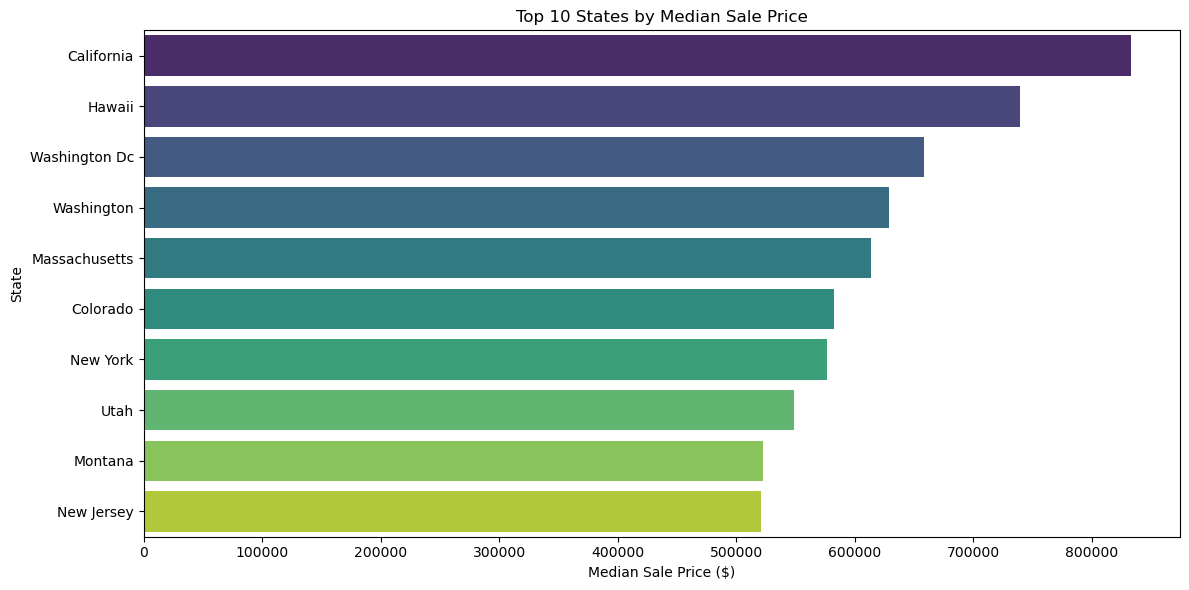

In [2]:
# Top 10 states by median sale price

top10_sale_price = output[['display_name', 'median_sale_price']].copy()
top10_sale_price['median_sale_price_numeric'] = top10_sale_price['median_sale_price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
top10_sale_price = top10_sale_price.sort_values(by='median_sale_price_numeric', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top10_sale_price, x='median_sale_price_numeric', y='display_name', palette='viridis')
plt.title('Top 10 States by Median Sale Price')
plt.xlabel('Median Sale Price ($)')
plt.ylabel('State')
plt.tight_layout()
plt.show()


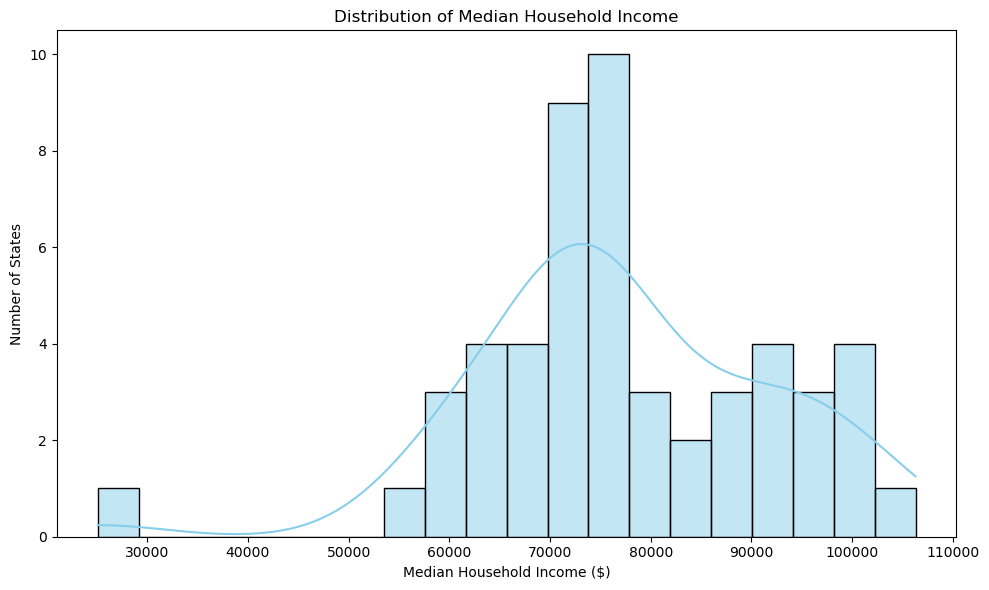

In [3]:
# Distribution plot of median household income

mhi_values = output['median_household_income'].replace({'\$': '', ',': ''}, regex=True).astype(float)

plt.figure(figsize=(10, 6))
sns.histplot(mhi_values, bins=20, kde=True, color='skyblue')
plt.title('Distribution of Median Household Income')
plt.xlabel('Median Household Income ($)')
plt.ylabel('Number of States')
plt.tight_layout()
plt.show()


C:\Users\adity\AppData\Local\Temp\ipykernel_24416\2312244665.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=affordability, x='house_affordability_ratio', y='display_name', palette='coolwarm')


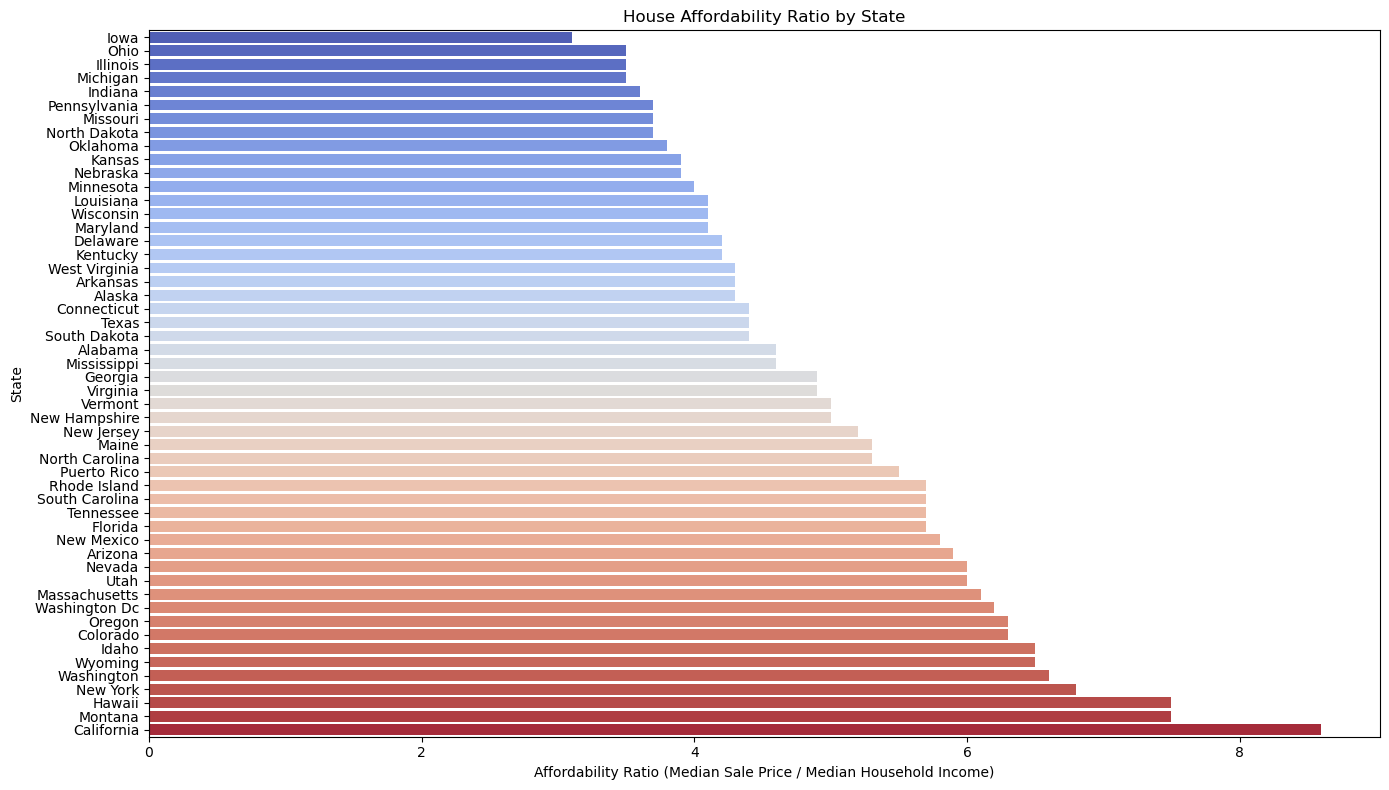

In [4]:
# Bar plot of house affordability ratio

affordability = output[['display_name', 'house_affordability_ratio']].copy()
affordability['house_affordability_ratio'] = affordability['house_affordability_ratio'].replace('', np.nan).astype(float)
affordability = affordability.dropna().sort_values(by='house_affordability_ratio', ascending=True)

plt.figure(figsize=(14, 8))
sns.barplot(data=affordability, x='house_affordability_ratio', y='display_name', palette='coolwarm')
plt.title('House Affordability Ratio by State')
plt.xlabel('Affordability Ratio (Median Sale Price / Median Household Income)')
plt.ylabel('State')
plt.tight_layout()
plt.show()


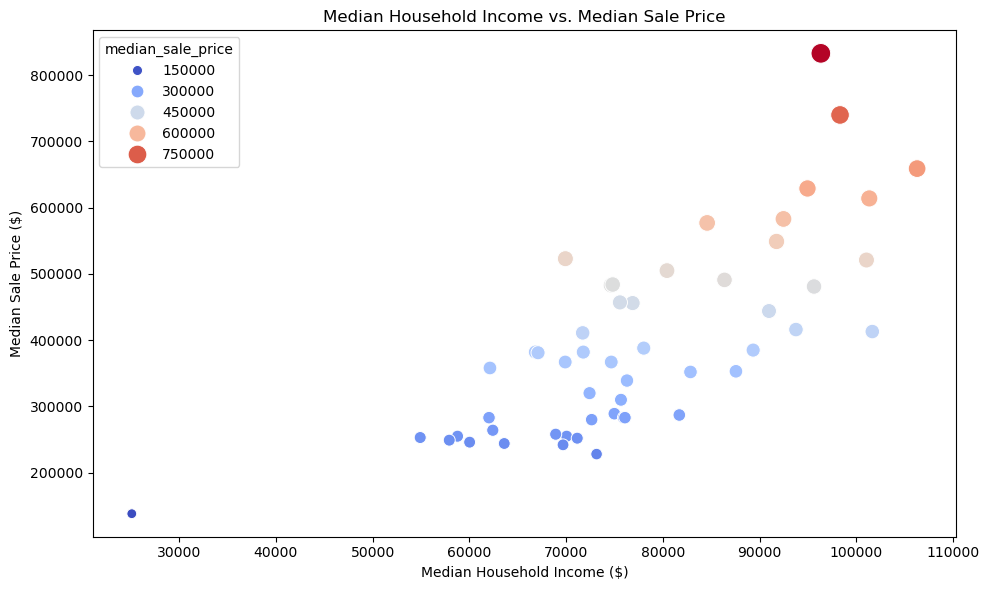

In [5]:
# Scatter plot of median household income vs. median sale price

income_price = output[['median_household_income', 'median_sale_price']].copy()
income_price['median_household_income'] = income_price['median_household_income'].replace({'\$': '', ',': ''}, regex=True).astype(float)
income_price['median_sale_price'] = income_price['median_sale_price'].replace({'\$': '', ',': ''}, regex=True).astype(float)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=income_price, x='median_household_income', y='median_sale_price', hue='median_sale_price', palette='coolwarm', size='median_sale_price', sizes=(50, 200))
plt.title('Median Household Income vs. Median Sale Price')
plt.xlabel('Median Household Income ($)')
plt.ylabel('Median Sale Price ($)')
plt.tight_layout()
plt.show()


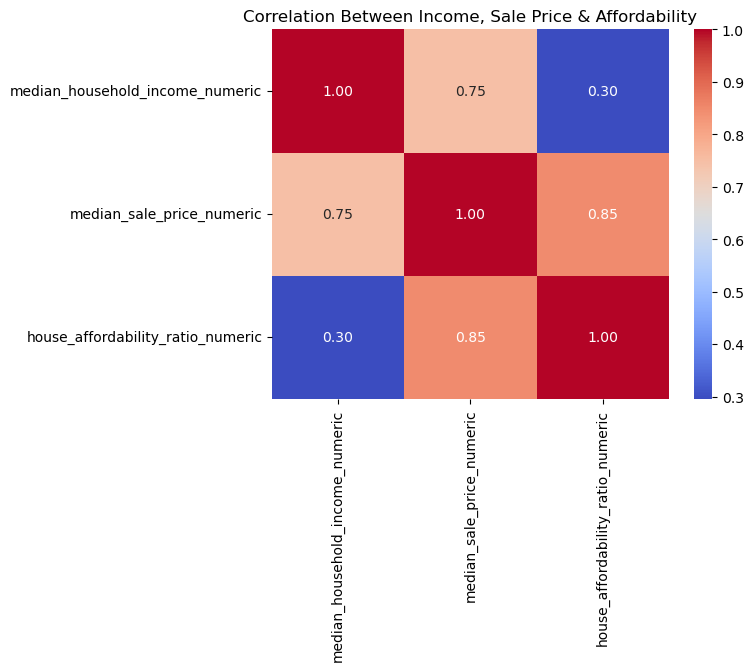

In [7]:
# Recompute numeric versions temporarily for correlation analysis
output['median_household_income_numeric'] = output['median_household_income'].replace({'\$': '', ',': ''}, regex=True).astype(float)
output['median_sale_price_numeric'] = output['median_sale_price'].replace({'\$': '', ',': ''}, regex=True).astype(float)
output['house_affordability_ratio_numeric'] = pd.to_numeric(output['house_affordability_ratio'], errors='coerce')

# Select relevant columns
metrics = output[['median_household_income_numeric', 'median_sale_price_numeric', 'house_affordability_ratio_numeric']]

# Plot the heatmap
sns.heatmap(metrics.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Income, Sale Price & Affordability')
plt.show()
